In [1]:
import os
import numpy as np
from PIL import Image

import torch
from torch.utils import data

from torchvision import transforms
from torchvision.datasets import MNIST
import matplotlib.pyplot as plt

In [6]:
# Adapted from https://github.com/clovaai/rebias/blob/master/datasets/colour_mnist.py

class BiasedMNIST(MNIST):
    """A base class for Biased-MNIST.
    We manually select ten colours to synthetic colour bias. (See `COLOUR_MAP` for the colour configuration)
    Usage is exactly same as torchvision MNIST dataset class.
    You have two paramters to control the level of bias.
    Parameters
    ----------
    root : str
        path to MNIST dataset.
    data_label_correlation : float, default=1.0
        Here, each class has the pre-defined colour (bias).
        data_label_correlation, or `rho` controls the level of the dataset bias.
        A sample is coloured with
            - the pre-defined colour with probability `rho`,
            - coloured with one of the other colours with probability `1 - rho`.
              The number of ``other colours'' is controlled by `n_confusing_labels` (default: 9).
        Note that the colour is injected into the background of the image (see `_binary_to_colour`).
        Hence, we have
            - Perfectly biased dataset with rho=1.0
            - Perfectly unbiased with rho=0.1 (1/10) ==> our ``unbiased'' setting in the test time.
        In the paper, we explore the high correlations but with small hints, e.g., rho=0.999.
    n_confusing_labels : int, default=9
        In the real-world cases, biases are not equally distributed, but highly unbalanced.
        We mimic the unbalanced biases by changing the number of confusing colours for each class.
        In the paper, we use n_confusing_labels=9, i.e., during training, the model can observe
        all colours for each class. However, you can make the problem harder by setting smaller n_confusing_labels, e.g., 2.
        We suggest to researchers considering this benchmark for future researches.
    """

    COLOUR_MAP = [[255, 0, 0], [0, 255, 0], [0, 0, 255], [225, 225, 0], [225, 0, 225],
                  [0, 255, 255], [255, 128, 0], [255, 0, 128], [128, 0, 255], [128, 128, 128]]

    def __init__(self, root, train=True, transform=None, target_transform=None,
                 download=False, data_label_correlation=1.0, n_confusing_labels=9, do_shuffle=True):
        super().__init__(root, train=train, transform=transform,
                         target_transform=target_transform,
                         download=download)
        self.data_label_correlation = data_label_correlation
        self.n_confusing_labels = n_confusing_labels
        self.do_shuffle = do_shuffle
        self.data, self.targets, self.biased_targets = self.build_biased_mnist()

        
        indices = np.arange(len(self.data))
        
        self._shuffle(indices)
        self.data = self.data[indices].numpy()
        self.targets = self.targets[indices]
        self.biased_targets = self.biased_targets[indices]

    @property
    def raw_folder(self):
        return os.path.join(self.root, 'raw')

    @property
    def processed_folder(self):
        return os.path.join(self.root, 'processed')

    def _shuffle(self, iteratable):
        if self.do_shuffle:
            np.random.shuffle(iteratable)

    def _make_biased_mnist(self, indices, label):
        raise NotImplementedError

    def _update_bias_indices(self, bias_indices, label):
        """
        Args:
            bias_indices: 
        
        """
        if self.n_confusing_labels > 9 or self.n_confusing_labels < 1:
            raise ValueError(self.n_confusing_labels)

        indices = np.where((self.targets == label).numpy())[0]
        self._shuffle(indices)
        indices = torch.LongTensor(indices)

        n_samples = len(indices)
        n_correlated_samples = int(n_samples * self.data_label_correlation)
        n_decorrelated_per_class = int(np.ceil((n_samples - n_correlated_samples) / (self.n_confusing_labels)))

        correlated_indices = indices[:n_correlated_samples]
        bias_indices[label] = torch.cat([bias_indices[label], correlated_indices])

        decorrelated_indices = torch.split(indices[n_correlated_samples:], n_decorrelated_per_class)

        other_labels = [_label % 10 for _label in range(label + 1, label + 1 + self.n_confusing_labels)]
        self._shuffle(other_labels)

        for idx, _indices in enumerate(decorrelated_indices):
            _label = other_labels[idx]
            bias_indices[_label] = torch.cat([bias_indices[_label], _indices])

    def build_biased_mnist(self):
        """
        Returns:
            data: batch of images of shape (N, 28, 28, 3)
            targets: labels of shape (N) corresponding to data
            biased_targets: index of background color to be used, shaped (N)
        """
        n_labels = self.targets.max().item() + 1
        bias_indices = {label: torch.LongTensor() for label in range(n_labels)}
        
        for label in range(n_labels):
            self._update_bias_indices(bias_indices, label)

        data = torch.ByteTensor()
        targets = torch.LongTensor()
        biased_targets = []

        for bias_label, indices in bias_indices.items():
            _data, _targets = self._make_biased_mnist(indices, bias_label)
            data = torch.cat([data, _data])
            targets = torch.cat([targets, _targets])
            biased_targets.extend([bias_label] * len(indices))

        biased_targets = torch.LongTensor(biased_targets)
        return data, targets, biased_targets

    def __getitem__(self, index):
        img, target = self.data[index], int(self.targets[index])
        img = Image.fromarray(img, mode='RGB')

        if self.transform is not None:
            img = self.transform(img)
        if self.target_transform is not None:
            target = self.target_transform(target)

        return img, target, int(self.biased_targets[index])
    
    
    
class ColourBiasedMNIST(BiasedMNIST):
    def __init__(self, root, train=True, transform=None, target_transform=None,
                 download=False, data_label_correlation=1.0, n_confusing_labels=9, do_shuffle=True):
        super(ColourBiasedMNIST, self).__init__(root, train=train, transform=transform,
                                                target_transform=target_transform,
                                                download=download,
                                                data_label_correlation=data_label_correlation,
                                                n_confusing_labels=n_confusing_labels,
                                                do_shuffle=do_shuffle)

    def _binary_to_colour(self, data, colour):
        """
        Args:
            data: grey-scale image of shape (N, 28, 28)   
        Returns:
            RGB image of shape (N, 28, 28, 3)
        """
        
        fg_data = torch.zeros_like(data)
        fg_data[data != 0] = 255
        fg_data[data == 0] = 0
        fg_data = torch.stack([fg_data, fg_data, fg_data], dim=1)

        bg_data = torch.zeros_like(data)
        bg_data[data == 0] = 1
        bg_data[data != 0] = 0
        bg_data = torch.stack([bg_data, bg_data, bg_data], dim=3)
        bg_data = bg_data * torch.ByteTensor(colour)
        bg_data = bg_data.permute(0, 3, 1, 2)

        data = fg_data + bg_data
        data = data.permute(0, 2, 3, 1)
        return data

    def _make_biased_mnist(self, indices, label):
        """
        Args:
            indices: indices to be turned into biased images, shaped (N)
            label: a scalar index specifying a target colour to be used
        Returns:
            a tuple (images, labels)
        """
        return self._binary_to_colour(self.data[indices], self.COLOUR_MAP[label]), self.targets[indices]


In [7]:
# Defining parameters

root=os.path.join('data', 'new')
train=True
data_label_correlation = 1
n_confusing_labels = 9
batch_size = 50
num_workers = 1
do_shuffle=True

In [8]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5, 0.5, 0.5),
                         std=(0.5, 0.5, 0.5))])

mnist = MNIST(root, 
            train=train, 
            transform=transform,
            download=True)

dataset = ColourBiasedMNIST(root, 
                            train=train, 
                            transform=transform,
                            download=True, 
                            data_label_correlation=data_label_correlation,
                            n_confusing_labels=n_confusing_labels,
                            do_shuffle=do_shuffle)

dataloader = data.DataLoader(dataset=dataset,
                             batch_size=batch_size,
                             shuffle=True,
                             num_workers=num_workers,
                             pin_memory=True)

In [9]:
print(dataset.data.shape) 
print(dataset.train_data.shape) 
print(dataset.test_data.shape)
print(dataset.targets.shape)

print(mnist.data.shape)
print(mnist.train_data.shape)
print(mnist.test_data.shape)
print(mnist.targets.shape)

# dataset.test_data == dataset.train_data == dataset.data
print(torch.sum(mnist.test_data == mnist.train_data).item() / 60000)
print(torch.sum(torch.tensor(dataset.test_data == dataset.train_data)).item() / 60000 / 3)

(60000, 28, 28, 3)
(60000, 28, 28, 3)
(60000, 28, 28, 3)
torch.Size([60000])
torch.Size([60000, 28, 28])
torch.Size([60000, 28, 28])
torch.Size([60000, 28, 28])
torch.Size([60000])
784.0


E:\anaconda\envs\torch-env\lib\site-packages\torchvision\datasets\mnist.py:55: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")
E:\anaconda\envs\torch-env\lib\site-packages\torchvision\datasets\mnist.py:60: UserWarning: test_data has been renamed data
  warnings.warn("test_data has been renamed data")


784.0


In [10]:
dataset.data = dataset.data[0:50000]
dataset.targets = dataset.targets[0:50000]
dl = data.DataLoader(dataset, batch_size = 50)

In [11]:
print(dl.dataset.data.shape)
print(dl.dataset.targets.shape)

(50000, 28, 28, 3)
torch.Size([50000])


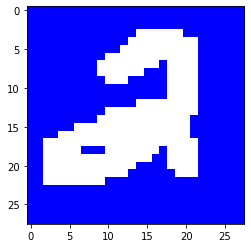

In [13]:
plt.clf()
img = dl.dataset.data[1]
img = np.swapaxes(img, 0, 1)
img = np.swapaxes(img, 1, 2)
plt.imshow(img)
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


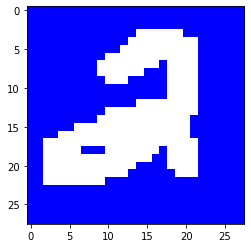

In [28]:
plt.clf()
# img_batch = np.array([dataset[0][0].data.numpy(), dataset[1][0].data.numpy()])
# img_batch.shape
img = dataset[1][0].data.numpy()
img = np.swapaxes(img, 0, 1)
img = np.swapaxes(img, 1, 2)

plt.imshow(img)
plt.show()